# LOCA - Dolan Creek WS: Create Precipitation Time Series 

Want to create a single precipitation time series for the watershed from LOCA values

To do this:

1. Load the area weighting for grid cells for the watershed
2. Need to go through the monthly wet days pickle archive and reconstruction time series for each grid cell and model
3. Calculate the area-weighted time series for each grid cell location and model 
4. Generate an average time series across the 64 simulations
5. Use this final average to make cumulative mass curve

## Imports and Parameters

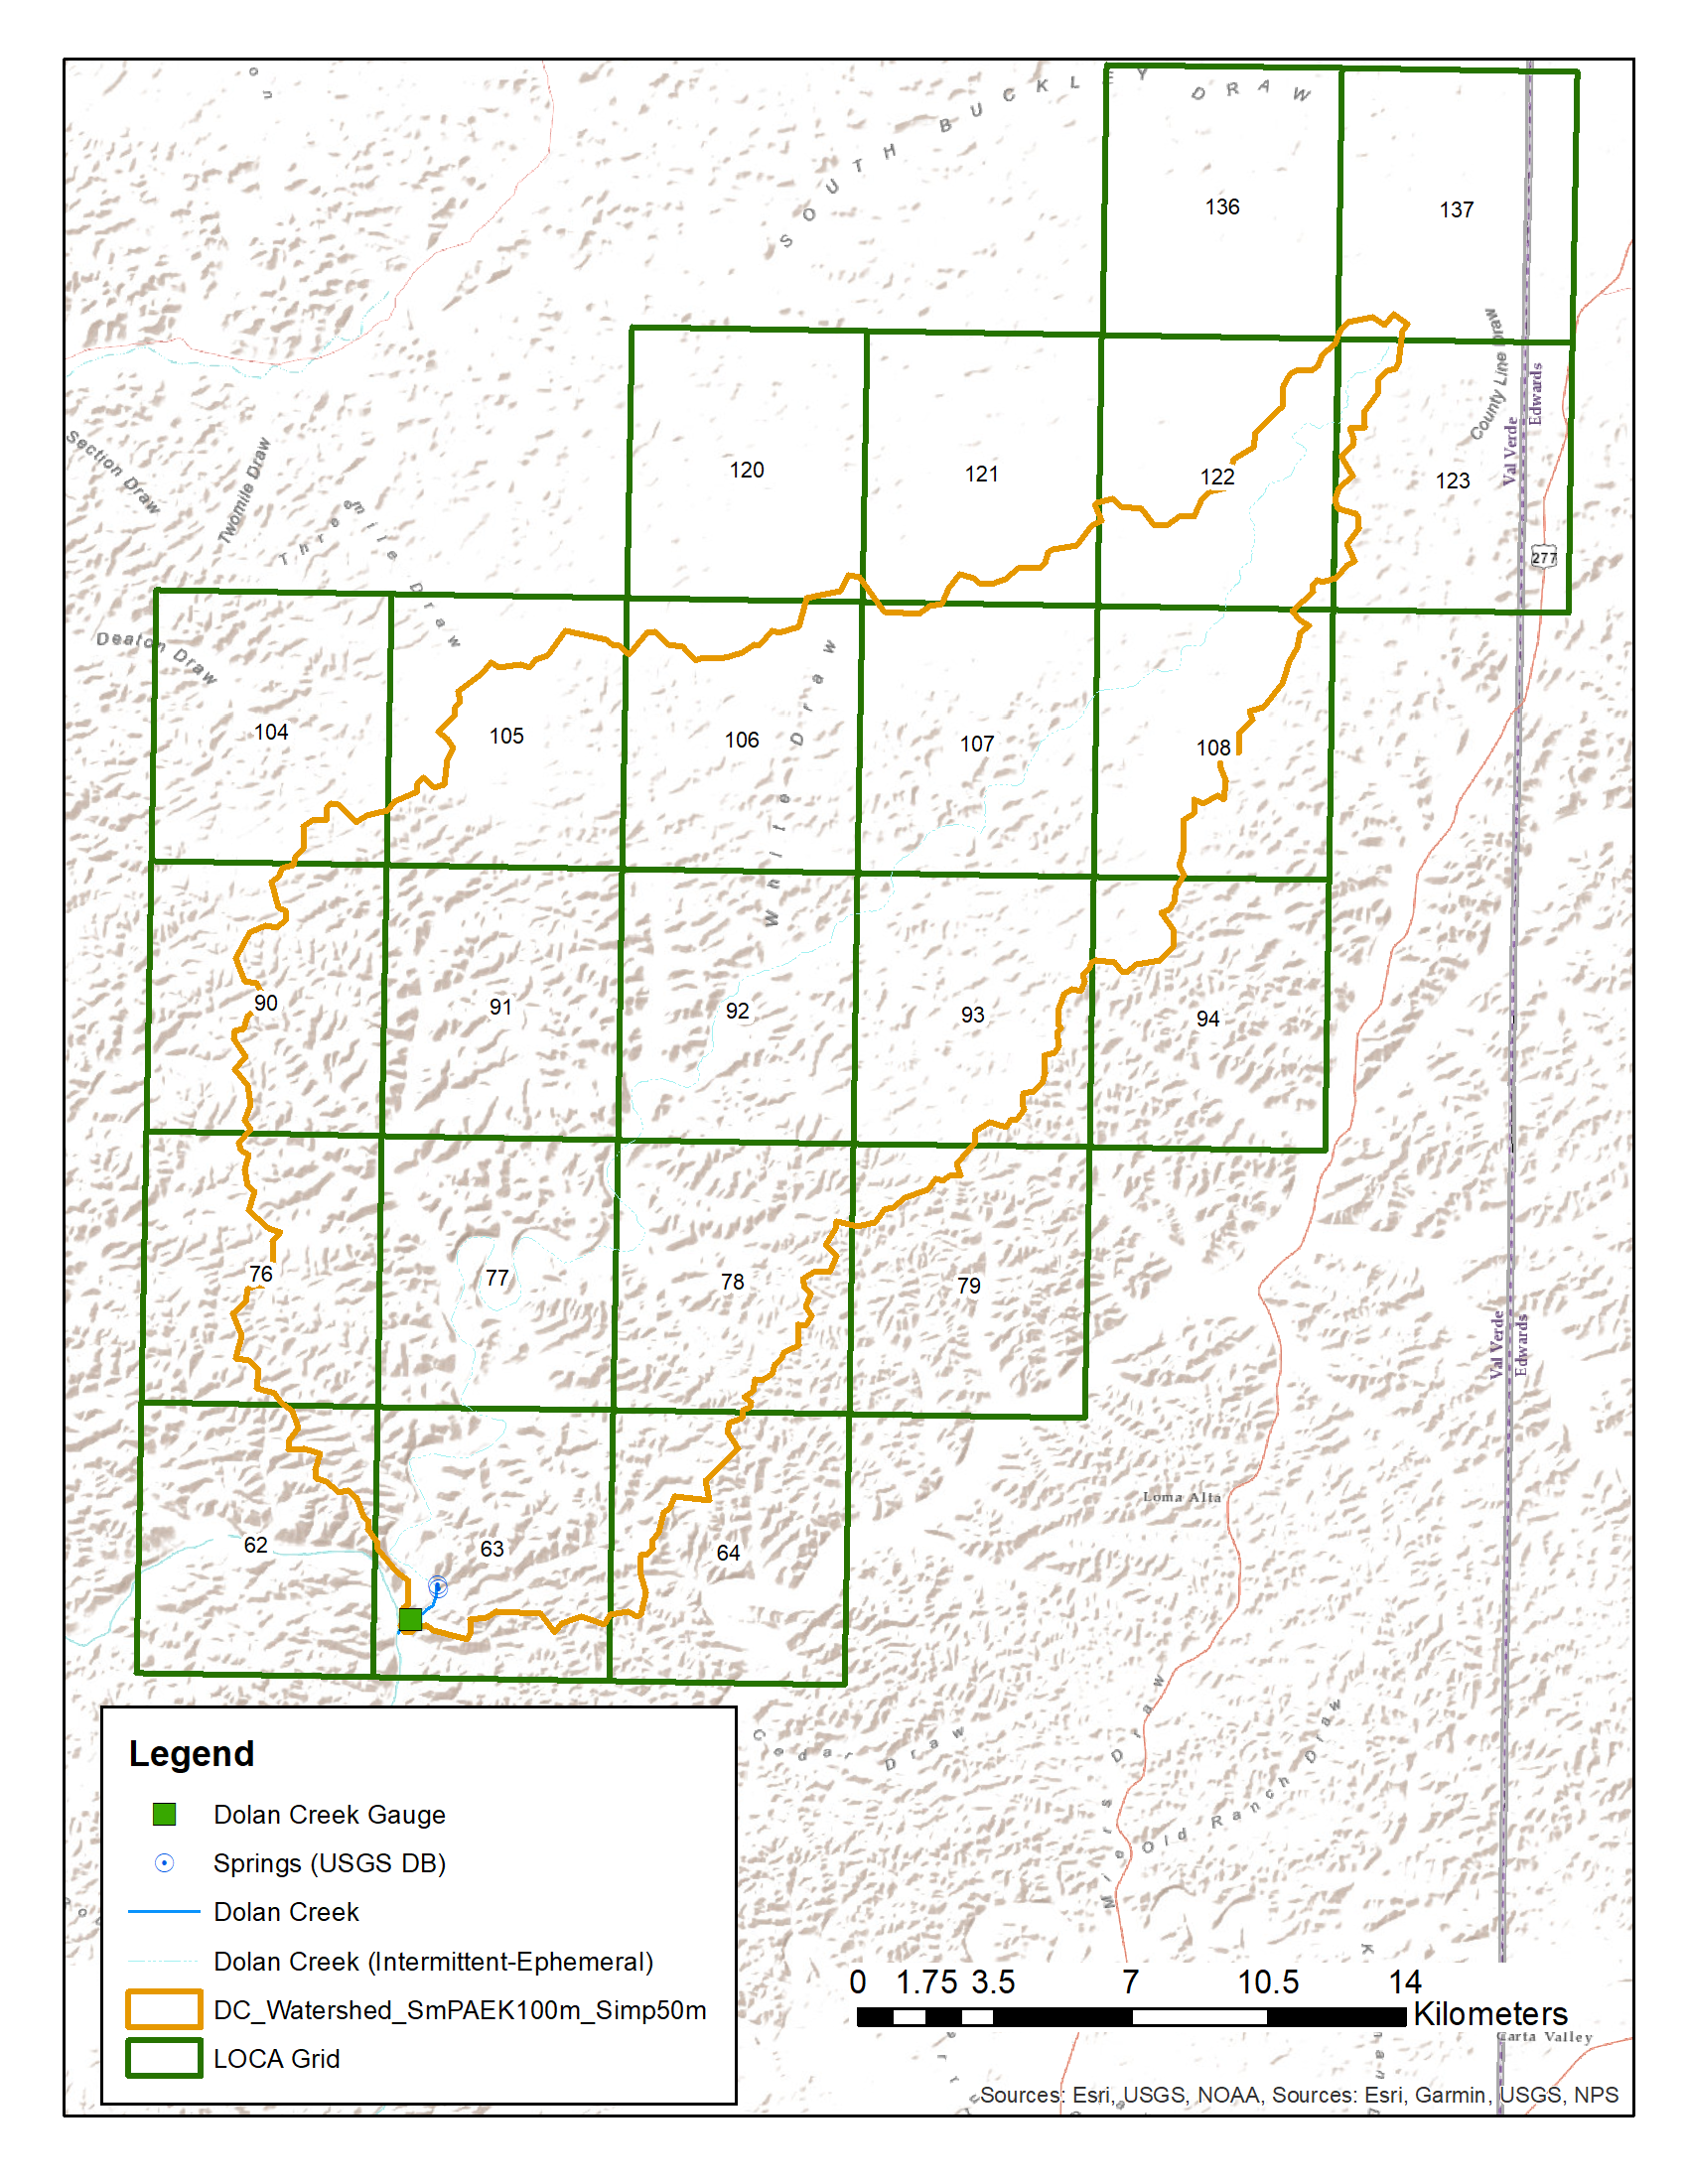

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stoch' \
                 r'astic_CC_Recharge\GIS\Images\PNG\CMIP5_Climate_Grid.png', width=800)

In [2]:
%matplotlib inline

In [3]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
from math import exp
import geopandas as gpd
import re

In [4]:
IN_WGHT = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\NumMode' \
          r'l\HSPF\GIS\Shapefiles\DCWS_LOCA_Weights.shp'

In [5]:
OUT_WS = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\Wea' \
         r'ther\One_WS'

In [6]:
IN_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\JN' \
         r'otes\Processed\CMIP5'
MONTH_D1 = "AllMonth_1981-2010.pickle"
MONTH_P1 = "AllMonth_LOCA_2011-2040.pickle"
MONTH_P2 = "AllMonth_LOCA_2041-2070.pickle"
MONTH_P3 = "AllMonth_LOCA_2071-2100.pickle"

In [7]:
WS_GridIds = [ 62, 63, 64, 76, 77, 78, 79, 90, 91, 92, 93, 94, 104, 105, 106, 107, 108, 
               120, 121, 122, 123, 136, 137 ]

In [8]:
ExModNum = lambda GId: int( (re.match( r'M(.*[0-9])_(.*[0-9])', GId )).group(1) )
ExGridNum = lambda GId: int( (re.match( r'M(.*[0-9])_(.*[0-9])', GId )).group(2) )

## LOCA Grid Weights

In [9]:
gpdWeights = gpd.read_file(IN_WGHT)

In [10]:
display( HTML( gpdWeights.head().to_html() ) )

In [11]:
AllCols = list( gpdWeights.columns )
AllCols

['Cell_Id', 'Tot_Area', 'Clp_Area', 'Weight', 'Rel_WS', 'geometry']

In [12]:
UseInd = gpdWeights[AllCols[0]].tolist()
TArea = gpdWeights[AllCols[1]].to_numpy()
CArea = gpdWeights[AllCols[2]].to_numpy()
Weight = gpdWeights[AllCols[3]].to_numpy()

In [13]:
DataDict = { AllCols[1]: TArea,
             AllCols[2]: CArea,
             AllCols[3]: Weight,
           }
WeightsDF = pd.DataFrame( index=UseInd, data=DataDict )

In [14]:
display( HTML( WeightsDF.head().to_html() ) )

## Use Monthly Outputs to Make Cumulative

In [15]:
LOCA_GRID_END = 168       # the last LOCA grid cell

### 1981-2010

In [16]:
InFiler = os.path.normpath( os.path.join( IN_DIR, MONTH_D1 ) )
AllDF = pd.read_pickle( InFiler )

In [17]:
display( HTML( AllDF.head().to_html() ) )

In [18]:
ModelGridCols = list( AllDF.columns )
len( ModelGridCols )

16296

In [19]:
UseCols = list()
for tCol in ModelGridCols:
    iGridId = int( tCol.split('_')[1] )
    if iGridId in WS_GridIds:
        UseCols.append( tCol )
    # end of if
# end of for
len(UseCols)

1472

In [20]:
NumCols = len(UseCols)
NumGrid = len(WS_GridIds)
NumModel = NumCols/NumGrid
NumModel

64.0

In [21]:
MonPreDF = AllDF[UseCols].copy()

In [22]:
display( HTML( MonPreDF.head().to_html() ) )

In [23]:
ModelGridCols = list( MonPreDF.columns )

In [24]:
t1 = ModelGridCols[0]
t1

'M1_62'

In [25]:
ExModNum(t1), ExGridNum(t1)

(1, 62)

In [26]:
MonIndex = MonPreDF.index.to_list()
MonIndex[:5]

[Timestamp('1981-01-01 00:00:00', freq='MS'),
 Timestamp('1981-02-01 00:00:00', freq='MS'),
 Timestamp('1981-03-01 00:00:00', freq='MS'),
 Timestamp('1981-04-01 00:00:00', freq='MS'),
 Timestamp('1981-05-01 00:00:00', freq='MS')]

In [27]:
DFDict = dict()
for tCol in ModelGridCols:
    cGridNo = ExGridNum(tCol)
    cModelNo = ExModNum(tCol)
    cVals = MonPreDF[tCol].to_numpy()
    if cModelNo in DFDict.keys():
        DFDict[cModelNo][cGridNo] = cVals
    else:
        newDF = pd.DataFrame( data={ cGridNo : cVals, }, index=MonIndex )
        DFDict[cModelNo] = newDF
    # end of if
# end of for

In [28]:
ModelInds = sorted(DFDict.keys())
NumModel = len( ModelInds )
NumModel

64

In [29]:
t1 = ModelInds[0]
tDF = DFDict[t1]

In [30]:
display( HTML( tDF.head().to_html() ) )

In [31]:
# make a function to calculate the weighted value
def MakeAreaWeightValue( GridIds, WDict, row ):
    """Function to calculate the area weighted value from a dictionary of weights
    
    Args:
        GridIds (list): list containing the keys for the dictionary
        WDict (dict): keys= column names, values = weight (weights should sum to 1.0)
        row (pd.row): row from a data frame
        
    Returns:
        Weighted value
    """
    retVal = 0.0
    for gG in GridIds:
        cVal = float( row[gG] )
        wVal = WDict[gG]
        retVal += ( cVal * wVal )
    # end for
    return retVal

In [32]:
WeightDict = dict( zip( WeightsDF.index.tolist(), WeightsDF['Weight'].tolist() ) )
sum( WeightDict.values() )

1.0001862804713249

In [33]:
WeightDict

{62: 0.009328647516668,
 63: 0.068952158093452,
 64: 0.020404011011124,
 76: 0.04847864434123,
 77: 0.090688988566399,
 78: 0.076246708631516,
 79: 0.008581403642893,
 90: 0.050150163471699,
 91: 0.090708985924721,
 92: 0.090659566223621,
 93: 0.078193530440331,
 94: 0.009646391496062,
 104: 0.005936441477388,
 105: 0.058582652360201,
 106: 0.079242281615734,
 107: 0.089871183037758,
 108: 0.055458303540945,
 120: 0.001069709542207,
 121: 0.00902840308845,
 122: 0.048809297382832,
 123: 0.008430456742644,
 136: 2.880122565e-06,
 137: 0.001715472200885}

In [ ]:
iCnt = 0
for tCol in ModelInds:
    mDF = DFDict[tCol]
    numRows = len( mDF )
    mDF['WAAve'] = 0.0
    for iI in range(numRows):
        cInd = mDF.index[iI]
        cRow = mDF.iloc[iI]
        mDF.at[cInd, 'WAAve'] = MakeAreaWeightValue( WS_GridIds, WeightDict, cRow )
    # end for
    if iCnt == 0:
        ModelAveDF = pd.DataFrame( data={tCol: mDF['WAAve'].to_numpy(), }, index=MonIndex )
    else:
        ModelAveDF[tCol] = mDF['WAAve'].to_numpy()
    # end of if
    iCnt += 1
# end of for

In [ ]:
display( HTML( ModelAveDF.head().to_html() ) )

In [ ]:
ModelAveDF["Total"] = ModelAveDF.sum( axis=1 )

In [ ]:
ModelAveDF["Ave"] = ModelAveDF["Total"] / NumModel

In [ ]:
display( HTML( ModelAveDF.head().to_html() ) )

Output to a spreadsheet

In [ ]:
OutFiler = os.path.normpath( os.path.join( OUT_WS, "LOCA_OneWS_Precip_1981-2010.xlsx" ) )
with pd.ExcelWriter(OutFiler) as writer:
    ModelAveDF.to_excel( writer, sheet_name="Averages", na_rep=str(np.nan), index_label="Date" )
    for tCol in ModelInds:
        mDF = DFDict[tCol]
        mDF.to_excel( writer, sheet_name="%d" % tCol, na_rep=str(np.nan), index_label="Date" )
    # end for
# end and close file

### 2011 - 2040

In [ ]:
InFiler = os.path.normpath( os.path.join( IN_DIR, MONTH_P1 ) )
AllDF = pd.read_pickle( InFiler )

In [ ]:
display( HTML( AllDF.head().to_html() ) )

In [ ]:
UseCols = list()
for tCol in ModelGridCols:
    iGridId = int( tCol.split('_')[1] )
    if iGridId in WS_GridIds:
        UseCols.append( tCol )
    # end of if
# end of for
len(UseCols)

In [ ]:
NumCols = len(UseCols)
NumGrid = len(WS_GridIds)
NumModel = NumCols/NumGrid
NumModel

In [ ]:
MonPreDF = AllDF[UseCols].copy()

In [ ]:
ModelGridCols = list( MonPreDF.columns )

In [ ]:
MonIndex = MonPreDF.index.to_list()
MonIndex[:5]

In [ ]:
DFDict = dict()
for tCol in ModelGridCols:
    cGridNo = ExGridNum(tCol)
    cModelNo = ExModNum(tCol)
    cVals = MonPreDF[tCol].to_numpy()
    if cModelNo in DFDict.keys():
        DFDict[cModelNo][cGridNo] = cVals
    else:
        newDF = pd.DataFrame( data={ cGridNo : cVals, }, index=MonIndex )
        DFDict[cModelNo] = newDF
    # end of if
# end of for

In [ ]:
ModelInds = sorted(DFDict.keys())
NumModel = len( ModelInds )
NumModel

In [ ]:
iCnt = 0
for tCol in ModelInds:
    mDF = DFDict[tCol]
    numRows = len( mDF )
    mDF['WAAve'] = 0.0
    for iI in range(numRows):
        cInd = mDF.index[iI]
        cRow = mDF.iloc[iI]
        mDF.at[cInd, 'WAAve'] = MakeAreaWeightValue( WS_GridIds, WeightDict, cRow )
    # end for
    if iCnt == 0:
        ModelAveDF = pd.DataFrame( data={tCol: mDF['WAAve'].to_numpy(), }, index=MonIndex )
    else:
        ModelAveDF[tCol] = mDF['WAAve'].to_numpy()
    # end of if
    iCnt += 1
# end of for

In [ ]:
ModelAveDF["Total"] = ModelAveDF.sum( axis=1 )

In [ ]:
ModelAveDF["Ave"] = ModelAveDF["Total"] / NumModel

In [ ]:
OutFiler = os.path.normpath( os.path.join( OUT_WS, "LOCA_OneWS_Precip_2011-2040.xlsx" ) )
with pd.ExcelWriter(OutFiler) as writer:
    ModelAveDF.to_excel( writer, sheet_name="Averages", na_rep=str(np.nan), index_label="Date" )
    for tCol in ModelInds:
        mDF = DFDict[tCol]
        mDF.to_excel( writer, sheet_name="%d" % tCol, na_rep=str(np.nan), index_label="Date" )
    # end for
# end and close file

### 2041-2070

In [ ]:
InFiler = os.path.normpath( os.path.join( IN_DIR, MONTH_P2 ) )
AllDF = pd.read_pickle( InFiler )

In [ ]:
UseCols = list()
for tCol in ModelGridCols:
    iGridId = int( tCol.split('_')[1] )
    if iGridId in WS_GridIds:
        UseCols.append( tCol )
    # end of if
# end of for
len(UseCols)

In [ ]:
NumCols = len(UseCols)
NumGrid = len(WS_GridIds)
NumModel = NumCols/NumGrid
NumModel

In [ ]:
MonPreDF = AllDF[UseCols].copy()

In [ ]:
ModelGridCols = list( MonPreDF.columns )

In [ ]:
MonIndex = MonPreDF.index.to_list()

In [ ]:
DFDict = dict()
for tCol in ModelGridCols:
    cGridNo = ExGridNum(tCol)
    cModelNo = ExModNum(tCol)
    cVals = MonPreDF[tCol].to_numpy()
    if cModelNo in DFDict.keys():
        DFDict[cModelNo][cGridNo] = cVals
    else:
        newDF = pd.DataFrame( data={ cGridNo : cVals, }, index=MonIndex )
        DFDict[cModelNo] = newDF
    # end of if
# end of for

In [ ]:
ModelInds = sorted(DFDict.keys())
NumModel = len( ModelInds )
NumModel

In [ ]:
iCnt = 0
for tCol in ModelInds:
    mDF = DFDict[tCol]
    numRows = len( mDF )
    mDF['WAAve'] = 0.0
    for iI in range(numRows):
        cInd = mDF.index[iI]
        cRow = mDF.iloc[iI]
        mDF.at[cInd, 'WAAve'] = MakeAreaWeightValue( WS_GridIds, WeightDict, cRow )
    # end for
    if iCnt == 0:
        ModelAveDF = pd.DataFrame( data={tCol: mDF['WAAve'].to_numpy(), }, index=MonIndex )
    else:
        ModelAveDF[tCol] = mDF['WAAve'].to_numpy()
    # end of if
    iCnt += 1
# end of for

In [ ]:
ModelAveDF["Total"] = ModelAveDF.sum( axis=1 )

In [ ]:
ModelAveDF["Ave"] = ModelAveDF["Total"] / NumModel

In [ ]:
OutFiler = os.path.normpath( os.path.join( OUT_WS, "LOCA_OneWS_Precip_2041-2070.xlsx" ) )
with pd.ExcelWriter(OutFiler) as writer:
    ModelAveDF.to_excel( writer, sheet_name="Averages", na_rep=str(np.nan), index_label="Date" )
    for tCol in ModelInds:
        mDF = DFDict[tCol]
        mDF.to_excel( writer, sheet_name="%d" % tCol, na_rep=str(np.nan), index_label="Date" )
    # end for
# end and close file

### 2071-2100

In [ ]:
InFiler = os.path.normpath( os.path.join( IN_DIR, MONTH_P3 ) )
AllDF = pd.read_pickle( InFiler )

In [ ]:
UseCols = list()
for tCol in ModelGridCols:
    iGridId = int( tCol.split('_')[1] )
    if iGridId in WS_GridIds:
        UseCols.append( tCol )
    # end of if
# end of for
len(UseCols)

In [ ]:
NumCols = len(UseCols)
NumGrid = len(WS_GridIds)
NumModel = NumCols/NumGrid
NumModel

In [ ]:
MonPreDF = AllDF[UseCols].copy()

In [ ]:
ModelGridCols = list( MonPreDF.columns )

In [ ]:
MonIndex = MonPreDF.index.to_list()

In [ ]:
DFDict = dict()
for tCol in ModelGridCols:
    cGridNo = ExGridNum(tCol)
    cModelNo = ExModNum(tCol)
    cVals = MonPreDF[tCol].to_numpy()
    if cModelNo in DFDict.keys():
        DFDict[cModelNo][cGridNo] = cVals
    else:
        newDF = pd.DataFrame( data={ cGridNo : cVals, }, index=MonIndex )
        DFDict[cModelNo] = newDF
    # end of if
# end of for

In [ ]:
ModelInds = sorted(DFDict.keys())
NumModel = len( ModelInds )
NumModel

In [ ]:
iCnt = 0
for tCol in ModelInds:
    mDF = DFDict[tCol]
    numRows = len( mDF )
    mDF['WAAve'] = 0.0
    for iI in range(numRows):
        cInd = mDF.index[iI]
        cRow = mDF.iloc[iI]
        mDF.at[cInd, 'WAAve'] = MakeAreaWeightValue( WS_GridIds, WeightDict, cRow )
    # end for
    if iCnt == 0:
        ModelAveDF = pd.DataFrame( data={tCol: mDF['WAAve'].to_numpy(), }, index=MonIndex )
    else:
        ModelAveDF[tCol] = mDF['WAAve'].to_numpy()
    # end of if
    iCnt += 1
# end of for

In [ ]:
ModelAveDF["Total"] = ModelAveDF.sum( axis=1 )

In [ ]:
ModelAveDF["Ave"] = ModelAveDF["Total"] / NumModel

In [ ]:
OutFiler = os.path.normpath( os.path.join( OUT_WS, "LOCA_OneWS_Precip_2071-2100.xlsx" ) )
with pd.ExcelWriter(OutFiler) as writer:
    ModelAveDF.to_excel( writer, sheet_name="Averages", na_rep=str(np.nan), index_label="Date" )
    for tCol in ModelInds:
        mDF = DFDict[tCol]
        mDF.to_excel( writer, sheet_name="%d" % tCol, na_rep=str(np.nan), index_label="Date" )
    # end for
# end and close file